In [2]:
pip install kaggle

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prashant268/chest-xray-covid19-pneumonia")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'chest-xray-covid19-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-covid19-pneumonia


In [4]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models
data_root = os.path.join(path, "Data")

train_dir = os.path.join(data_root, "train")
test_dir  = os.path.join(data_root, "test")

print("Train samples inside:", os.listdir(train_dir))
print("Test samples inside:", os.listdir(test_dir))


Train samples inside: ['PNEUMONIA', 'NORMAL', 'COVID19']
Test samples inside: ['PNEUMONIA', 'NORMAL', 'COVID19']


In [5]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=test_transform)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Classes:", train_dataset.classes)
print("Class to idx:", train_dataset.class_to_idx)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2)


Device: cuda
Train samples: 5144
Test samples: 1288
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA']
Class to idx: {'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


In [6]:


model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

num_features = model.fc.in_features
num_classes = len(train_dataset.classes)
model.fc = nn.Linear(num_features, num_classes)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


In [7]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total


In [8]:
num_epochs = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    test_loss,  test_acc  = evaluate(model, test_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}")


Epoch 1/5 | Train Acc: 0.912 | Test Acc: 0.962
Epoch 2/5 | Train Acc: 0.947 | Test Acc: 0.918
Epoch 3/5 | Train Acc: 0.955 | Test Acc: 0.950
Epoch 4/5 | Train Acc: 0.955 | Test Acc: 0.889
Epoch 5/5 | Train Acc: 0.957 | Test Acc: 0.941


In [9]:


model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes))


Confusion Matrix:
[[115   0   1]
 [  0 306  11]
 [  2  62 791]]

Classification Report:
              precision    recall  f1-score   support

     COVID19       0.98      0.99      0.99       116
      NORMAL       0.83      0.97      0.89       317
   PNEUMONIA       0.99      0.93      0.95       855

    accuracy                           0.94      1288
   macro avg       0.93      0.96      0.94      1288
weighted avg       0.95      0.94      0.94      1288



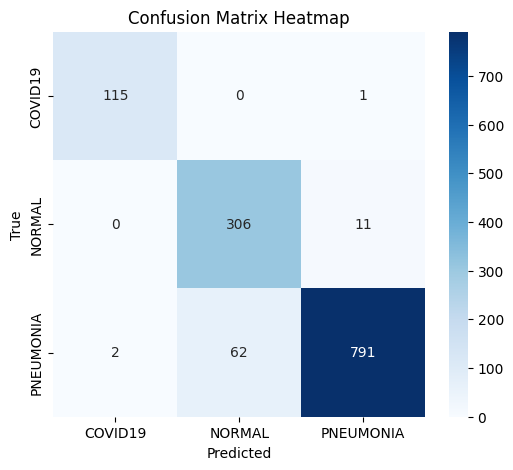

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [11]:
model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()

        all_probs.extend(probs)
        all_labels.extend(labels.cpu().numpy())

import numpy as np
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)


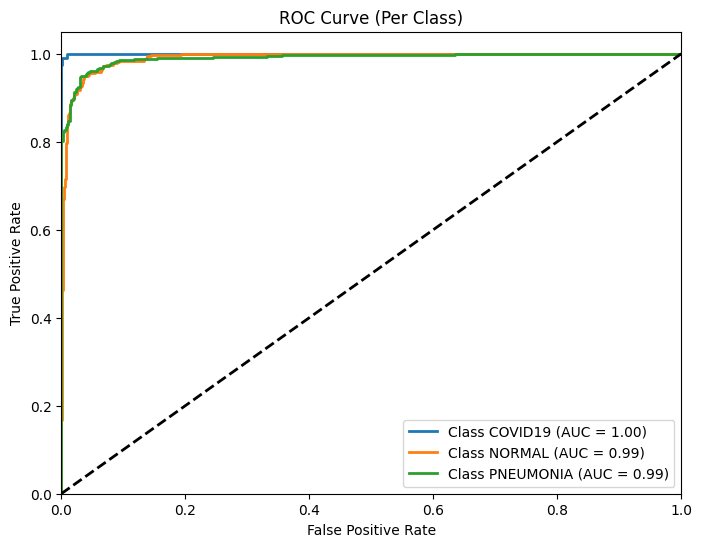

In [12]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


y_test_bin = label_binarize(all_labels, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(8, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {train_dataset.classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Per Class)")
plt.legend(loc="lower right")
plt.show()


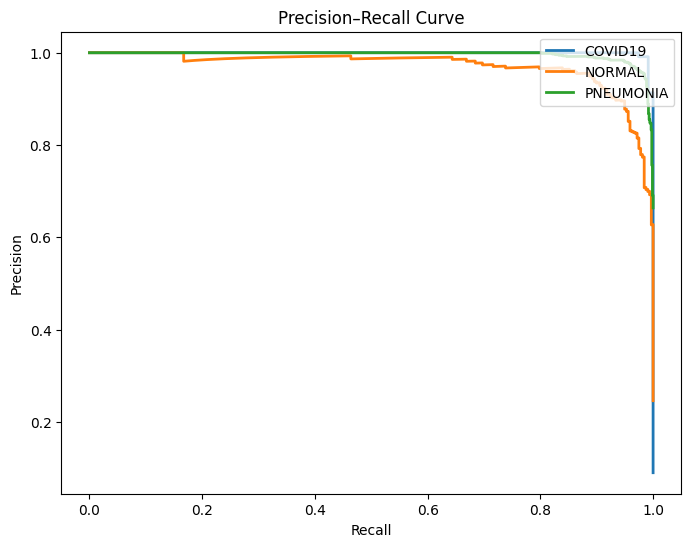

In [13]:
from sklearn.metrics import precision_recall_curve

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], all_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f"{train_dataset.classes[i]}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="upper right")
plt.show()


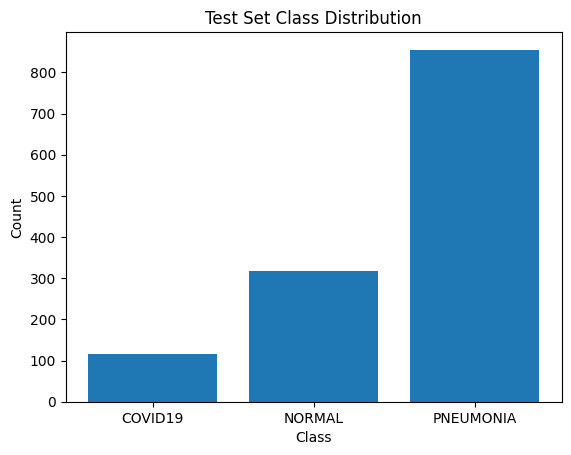

In [14]:
import collections
import matplotlib.pyplot as plt

counts = collections.Counter(all_labels)

plt.bar(train_dataset.classes, [counts[i] for i in range(len(train_dataset.classes))])
plt.title("Test Set Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()
